# Modelling

From the previous notebook **3. Feature exploration and selection.ipynb** we decided to go further with three approaches: the more data driven approach with two feature lists -an extended and a shorter- and a more pragmatic "domain" driven approach. For these three approaches we will first spot check some algoritms before we move to the phase of tuning hyperparameters. 

In our model procedure we will remove all rides from the latest 3 months. These rides will be used as a holdout set on which we will assess the final generalisation error. All other rides will be used in cross-validation, more specifically GroupKFold cross-validation. The reason for this is that we are actually looking at rides instead of individual (or cross-sectional) data points. If we would use "standard" KFold cross validation we would mix datapoints in the individual folds in train and test (so we leak information) while in fact we should split on ride level. 

This cross-validation procedure is a different procedure as in the **3. Feature exploration and selection.ipynb** notebook to get better idea on the model performance, i.e. generalization error. Here we get a better view om te model generalization by taking multiple train-test samples by using the folds and assessing the performance across the folds. In the previous notebook we just used a single train-test split.

For spot checking we will use GroupKFold cross-validation, while for hyperparameter tuning we will apply Nested GroupKFold cross-validation. This is a special case of cross-validation in which we have an outer cross-validation and an inner cross-validation (which is nested in the outer cross-validation) for hyperparameter optimization model selection. We will use random search for this. One of the benefits of this whole procedure is that overfitting in the hyperparameter search can be mitigated since only a part of the dataset is used by the outer cross-validation procedure. A downside is time to process since more models are estimated.

This should give a less biased estimate from the 
under this procedure, hyperparameter search does not have an opportunity to overfit the dataset as it is only exposed to a subset of the dataset provided by the outer cross-validation procedure. This reduces, if not eliminates, the risk of the search procedure overfitting the original dataset and should provide a less biased estimate of a tuned model’s performance on the dataset. 

This notebook is divided in 3 parts. The **(1)** first part is about spot checking some algorithms, namely Linear regression, ElasticNet, Decision Trees, LightGBM, XGBoost and Random Forest on each of the three feature lists. This list contains a mix of linear models (with and without regularization) and tree methods (normal, boosting and bagging method). The latter also take into account interactions and possible non-linearities. From this we will get a ranking of generalisation error. A 'real' first baseline model can be deducted. We will further decide on which other algorithm we want to use for hyperparameter tuning. 

After this **(2)** part we perform hyperparameter tuning using Nested GroupKFold cross-validation to test the procedure of hyperparameter tuning as a whole. We will do this for the three feature lists. 

The last **(3)** part shows the results of the 'baseline' model in comparison to a hyperparameter tuned model on our holdout period. We evaluate the total RMSE and the RMSE distribution on those rides. In addition we show the feature importances in the models.

Note: we ran modelling parts on AWS notebook instance (ml.c5.18xlarge) and even that took quite some time (e.g. 5 hours for the cross-validation). However, LightGBM procedures for hyperparameter tuning were done on a local machine (Intel® Core™ i7-8850H CPU @2.60GHz 2.59 GHz with 32GB RAM) as all processing thus far. Do note that each procedure can take a few hours to run

We define the start of the last 3 months since this date is used in various code below

In [3]:
date_start_holdout = '2020-09-01'

### Import libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.display.max_rows = 999
import pickle

import numpy as np
from numpy import mean
from numpy import std

import gc
from datetime import datetime

# preprocessing modules
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

# modelling modules
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# model selection
from sklearn import model_selection
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.model_selection import RandomizedSearchCV

# metrics
from sklearn.metrics import mean_squared_error, r2_score

# statistics
from scipy.stats import ttest_rel

# feature importances
import shap

# visualisations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# custom functions
from reduce_memory import reduce_mem_usage
from lightgbm_hyperparam_nested_cv_proc import lightgbm_hyperparam_nested_cv_proc
from model_performance_rides import metrics_feat_sel
from graph_rides_model_performance import graph_rides_model_performance

# set the random_state for reproducability
random_state = 101

## Part 1 Spot check algorithms

Here we spot check for each feature list a selection of models. After these procedures we analyse the results

In [5]:
# Read in the extended variable list

list_var_models_extended = pd.read_pickle('list_var_models_extended.pkl')

# Adjust list of variables
# remove temperature variable
list_var_models_extended.remove("temp")

# add hear rate, date and filename
list_var_models_extended.insert(0, "hr")
list_var_models_extended.insert(0, "date")
list_var_models_extended.insert(0, "filename")

# Remove records with Nans. Note these are at maximum 60 seconds since we work with max 60 seconds of moving averages
df_raw = pd.read_pickle('df_modelset_rider1_4.pkl')
df_raw = df_raw.dropna()
df_raw.reset_index(drop=True, inplace=True)

df_extended = df_raw[list_var_models_extended]

# free memory
del df_raw
gc.collect()

# define holdout set
df_extended_holdout = df_extended[df_extended['date'] >= date_start_holdout].drop(columns=['date'])
print('Amount of files in holdout', df_extended_holdout.filename.nunique())

# define trainset for cross-validation
df_extended_train = df_extended[df_extended['date'] < date_start_holdout].drop(columns=['date'])
print('Amount of files in training', df_extended_train.filename.nunique())

Amount of files in holdout 57
Amount of files in training 713


In [6]:
# make model list

models = []
models.append(('LinearRegression_extended', LinearRegression()))
models.append(('ElasticNet_extended', ElasticNet(random_state=random_state)))
models.append(('DecisionTree_extended', DecisionTreeRegressor(random_state=random_state)))
models.append(('LGB_extended', LGBMRegressor(n_estimators=50, random_state=random_state)))
models.append(('XGBRegressor_extended', XGBRegressor(n_estimators=50, random_state=random_state)))
models.append(('RandomForest_extended', RandomForestRegressor(n_estimators=50, random_state=random_state)))

# evaluate each model in turn
results = []
names = []
scoring = 'neg_root_mean_squared_error'

# define the groups for groupKfold
groups = df_extended_train['filename']
X = df_extended_train.drop(columns=['hr','filename'])
y = df_extended_train[['hr']]

# scale
scaler = StandardScaler()
scaler.fit(X)
X_train_scaled_dim = scaler.transform(X)

# free memory
del X
gc.collect()

# define GroupKFold amount of splits
kfold = model_selection.GroupKFold(n_splits=10)

start_time = datetime.now()

for name, model in models:
    cv_results = model_selection.cross_val_score(model, X_train_scaled_dim, y, groups=groups, cv=kfold, scoring=scoring, n_jobs=20)
    results.append(cv_results)
    names.append(name)

print('Time processing', datetime.now()-start_time)   

# save results
df_results_sel_extended = pd.DataFrame(results, index=names)
df_results_sel_extended.to_pickle('df_results_sel_extended.pkl')

Time processing 5:58:37.014132


## Reduced variable list

In [5]:
# Read in the extended variable list

list_var_models_reduced = pd.read_pickle('list_var_models_reduced.pkl')

# Adjust list of variables
# remove temperature variable
list_var_models_reduced.remove("temp")

# add hear rate, date and filename
list_var_models_reduced.insert(0, "hr")
list_var_models_reduced.insert(0, "date")
list_var_models_reduced.insert(0, "filename")
list_var_models_reduced.insert(0, "secs") # we add secs for plotting purposes later. Not for modelling since it was not in our reduced list

# Remove records with Nans. Note these are at maximum 60 seconds since we work with max 60 seconds of moving averages
df_raw = pd.read_pickle('df_modelset_rider1_4.pkl')
df_raw = df_raw.dropna()
df_raw.reset_index(drop=True, inplace=True)

df_reduced = df_raw[list_var_models_reduced]

# free memory
del df_raw
gc.collect()

# define holdout set
df_reduced_holdout = df_reduced[df_reduced['date'] >= date_start_holdout].drop(columns=['date','secs'])
print('Amount of files in holdout', df_reduced_holdout.filename.nunique())

# define trainset for cross-validation
df_reduced_train = df_reduced[df_reduced['date'] < date_start_holdout].drop(columns=['date','secs'])
print('Amount of files in training', df_reduced_train.filename.nunique())

Amount of files in holdout 57
Amount of files in training 713


In [8]:
# make model list

models = []
models.append(('LinearRegression_reduced', LinearRegression()))
models.append(('ElasticNet_reduced', ElasticNet(random_state=random_state)))
models.append(('DecisionTree_reduced', DecisionTreeRegressor(random_state=random_state)))
models.append(('LGB_reduced', LGBMRegressor(n_estimators=50, random_state=random_state)))
models.append(('XGBRegressor_reduced', XGBRegressor(n_estimators=50, random_state=random_state)))
models.append(('RandomForest_reduced', RandomForestRegressor(n_estimators=50, random_state=random_state)))

# evaluate each model in turn
results = []
names = []
scoring = 'neg_root_mean_squared_error'

# define the groups for groupKfold
groups = df_reduced_train['filename']
X = df_reduced_train.drop(columns=['hr','filename'])
y = df_reduced_train[['hr']]

# scale
scaler = StandardScaler()
scaler.fit(X)
X_train_scaled_dim = scaler.transform(X)

# free memory
del X
gc.collect()

# define GroupKFold amount of splits
kfold = model_selection.GroupKFold(n_splits=10)

start_time = datetime.now()

for name, model in models:
    cv_results = model_selection.cross_val_score(model, X_train_scaled_dim, y, groups=groups, cv=kfold, scoring=scoring, n_jobs=20)
    results.append(cv_results)
    names.append(name)

print('Time processing', datetime.now()-start_time)   

# save results
df_results_sel_reduced = pd.DataFrame(results, index=names)
df_results_sel_reduced.to_pickle('df_results_sel_reduced.pkl')

Time processing 2:00:35.048643


## Manual variable list

In [11]:
# Read in the extended variable list

list_var_models_manual = pd.read_pickle('list_var_models_manual.pkl')

# Remove records with Nans. Note these are at maximum 60 seconds since we work with max 60 seconds of moving averages
df_raw = pd.read_pickle('df_modelset_rider1_4.pkl')
df_raw = df_raw.dropna()
df_raw.reset_index(drop=True, inplace=True)

df_manual = df_raw[list_var_models_manual]

# free memory
del df_raw
gc.collect()

# define holdout set
df_manual_holdout = df_manual[df_manual['date'] >= date_start_holdout].drop(columns=['date'])
print('Amount of files in holdout', df_manual_holdout.filename.nunique())

# define trainset for cross-validation
df_manual_train = df_manual[df_manual['date'] < date_start_holdout].drop(columns=['date'])
print('Amount of files in training', df_manual_train.filename.nunique())

Amount of files in holdout 57
Amount of files in training 713


In [9]:
# make model list

models = []
models.append(('LinearRegression_manual', LinearRegression()))
models.append(('ElasticNet_manual', ElasticNet(random_state=random_state)))
models.append(('DecisionTree_manual', DecisionTreeRegressor(random_state=random_state)))
models.append(('LGB_manual', LGBMRegressor(n_estimators=50, random_state=random_state)))
models.append(('XGBRegressor_manual', XGBRegressor(n_estimators=50, random_state=random_state)))
models.append(('RandomForest_manual', RandomForestRegressor(n_estimators=50, random_state=random_state)))

# evaluate each model in turn
results = []
names = []
scoring = 'neg_root_mean_squared_error'

# define the groups for groupKfold
groups = df_manual_train['filename']
X = df_manual_train.drop(columns=['hr','filename'])
y = df_manual_train[['hr']]

# scale
scaler = StandardScaler()
scaler.fit(X)
X_train_scaled_dim = scaler.transform(X)

# free memory
del X
gc.collect()

# define GroupKFold amount of splits
kfold = model_selection.GroupKFold(n_splits=10)

start_time = datetime.now()

for name, model in models:
    cv_results = model_selection.cross_val_score(model, X_train_scaled_dim, y, groups=groups, cv=kfold, scoring=scoring, n_jobs=20)
    results.append(cv_results)
    names.append(name)
    
print('Time processing', datetime.now()-start_time)   

# save results
df_results_sel_manual = pd.DataFrame(results, index=names)
df_results_sel_manual.to_pickle('df_results_sel_manual.pkl')

Time processing 1:17:35.321527


### Analysis of results

In [48]:
# gather results of all feature selections
df_results_sel_extended = pd.read_pickle('df_results_sel_extended.pkl')
df_results_sel_reduced = pd.read_pickle('df_results_sel_reduced.pkl')
df_results_sel_manual = pd.read_pickle('df_results_sel_manual.pkl')

# calculate a mean of cross validation results to rank for plotting
df_results_tot = pd.concat([df_results_sel_extended,df_results_sel_reduced,df_results_sel_manual], axis=0)

df_results_tot = df_results_tot.abs()

# create model name column
df_results_tot = df_results_tot.reset_index().rename(columns={'index':'model_name'})

df_results_tot['mean_rmse'] = df_results_tot.median(axis=1)
df_results_tot = df_results_tot.sort_values(by=['mean_rmse'], ascending=True)
df_results_tot.drop(columns=['mean_rmse'], inplace=True)

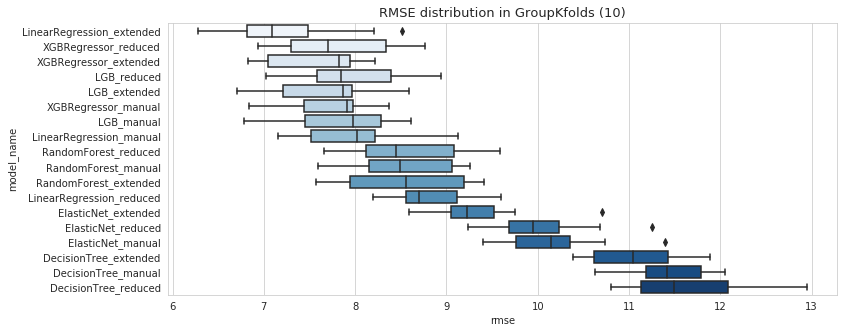

In [50]:
# change layout for plotting purposes
df_cv_rmse_plot = df_results_tot.melt(id_vars='model_name', 
        var_name="fold", 
        value_name="rmse")

# visualise
sns.set_style("whitegrid")

fig, ((ax1)) = plt.subplots(1, 1,figsize=(12,5))

sns.boxplot(y="model_name", x="rmse", data=df_cv_rmse_plot, orient="h",palette="Blues", ax=ax1)
ax1.set_title('RMSE distribution in GroupKfolds (10)', fontsize=13);

**Observations** 

We can see some interesting patterns in that our linear regression on the extended variable list actually seems to perform quite well. After that we see the boosing algorithms on the extended and reduced variable lists appearing. Also the two types (XGB, LightGBM) don't really differ that mucht in performance. 

For regression this is basically our result. We cannot do better by doing any further optimizations like hyperparameter tuning. So later on in this notebook we will fit the regression (only the _extended version_) on our total training period (3 years, excluding last 3 monthts) and do it's final evaluation on our out-of-time-data (last 3 months of our complete dataset).

We chose to pick one algorithm to tune further namely LightGBM. The reason for choosing this algorithm is based on the fact that it scored quite well initially compared to the other algorithms and its speed. We will first test the procedure of tuning the hyperparameters after we run it on our total trainingset. Due to memory restrictions we have to read in the data again for each dataset configuration since we also remove it.

Note: XGBoost tuning was also run via experiments not documented in this project. Results were in sync with LightGBM

## Part 2 Hyperparameter tuning

In this section we tune the hyperparameters for LightGBM on the extended, reduced and manual variables 

### Hyperparameter tuning procedure extended variable list

In [122]:
# read in total set
df_raw = pd.read_pickle('df_modelset_rider1_4.pkl')

# Read in the extended variable list
list_var_models_extended = pd.read_pickle('list_var_models_extended.pkl')

# Adjust list of variables
# remove temperature variable
list_var_models_extended.remove("temp");

# add heart rate, date and filename
list_var_models_extended.insert(0, "hr")
list_var_models_extended.insert(0, "date")
list_var_models_extended.insert(0, "filename")

# Remove records with Nans. Note these are at maximum 60 seconds since we work with max 60 seconds of moving averages
df_raw = df_raw.dropna()
df_raw.reset_index(drop=True, inplace=True)

df_extended = df_raw[list_var_models_extended]

# free memory
del df_raw
gc.collect()

# define holdout set
df_extended_holdout = df_extended[df_extended['date'] >= date_start_holdout].drop(columns=['date'])
print('Amount of files in holdout', df_extended_holdout.filename.nunique())

# define trainset for cross-validation
df_extended_train = df_extended[df_extended['date'] < date_start_holdout].drop(columns=['date'])
print('Amount of files in training', df_extended_train.filename.nunique())

Amount of files in holdout 57
Amount of files in training 713


In [4]:
# invoke function for extended modelling

lightgbm_hyperparam_nested_cv_proc(df_extended_train, proc_results_name = "list_extended_lgb")

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[50]	valid's rmse: 7.92008
>rmse=7.920, est=7.555, cfg={'colsample_bytree': 0.9042065818645788, 'min_child_samples': 308, 'min_child_weight': 1e-05, 'num_leaves': 46, 'reg_alpha': 50, 'reg_lambda': 0, 'subsample': 0.9338198537228333}
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[50]	valid's rmse: 6.68343
>rmse=6.683, est=7.662, cfg={'colsample_bytree': 0.9042065818645788, 'min_child_samples': 308, 'min_child_weight': 1e-05, 'num_leaves': 46, 'reg_alpha': 50, 'reg_lambda': 0, 'subsample': 0.9338198537228333}
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[50]	valid's rmse: 7.1

In [6]:
# free memory
del df_extended_train, df_extended_holdout
gc.collect()

380

### Hyperparameter tuning procedure reduced variable list

In [8]:
# read in total set
df_raw = pd.read_pickle('df_modelset_rider1_4.pkl')

# Read in the extended variable list
list_var_models_reduced = pd.read_pickle('list_var_models_reduced.pkl')

# Adjust list of variables
# remove temperature variable
list_var_models_reduced.remove("temp");
# add hear rate, date and filename
list_var_models_reduced.insert(0, "hr")
list_var_models_reduced.insert(0, "date")
list_var_models_reduced.insert(0, "filename")
list_var_models_reduced.insert(0, "secs") # we add secs for plotting purposes later. Not for modelling since it was not in our reduced list

# Remove records with Nans. Note these are at maximum 60 seconds since we work with max 60 seconds of moving averages
df_raw = df_raw.dropna()
df_raw.reset_index(drop=True, inplace=True)

df_reduced = df_raw[list_var_models_reduced]

# free memory
del df_raw
gc.collect()

# define holdout set
df_reduced_holdout = df_reduced[df_reduced['date'] >= date_start_holdout].drop(columns=['date','secs'])
print('Amount of files in holdout', df_reduced_holdout.filename.nunique())

# define trainset for cross-validation
df_reduced_train = df_reduced[df_reduced['date'] < date_start_holdout].drop(columns=['date','secs'])
print('Amount of files in training', df_reduced_train.filename.nunique())

Amount of files in holdout 57
Amount of files in training 713


In [13]:
# invoke function for reduced modelling
lightgbm_hyperparam_nested_cv_proc(df_reduced_train, proc_results_name = "list_reduced_lgb")

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[48]	valid's rmse: 8.11273
>rmse=8.113, est=7.929, cfg={'colsample_bytree': 0.9042065818645788, 'min_child_samples': 308, 'min_child_weight': 1e-05, 'num_leaves': 46, 'reg_alpha': 50, 'reg_lambda': 0, 'subsample': 0.9338198537228333}
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[50]	valid's rmse: 6.95804
>rmse=6.958, est=7.982, cfg={'colsample_bytree': 0.9042065818645788, 'min_child_samples': 308, 'min_child_weight': 1e-05, 'num_leaves': 46, 'reg_alpha': 50, 'reg_lambda': 0, 'subsample': 0.9338198537228333}
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[50]	valid's rmse: 7.2

In [16]:
# free memory
del df_reduced_train, df_reduced_holdout
gc.collect()

1296

### Hyperparameter tuning procedure manual variable list

In [96]:
# read in total set
df_raw = pd.read_pickle('df_modelset_rider1_4.pkl')

# Read in the extended variable list
list_var_models_manual = pd.read_pickle('list_var_models_manual.pkl')

# Remove records with Nans. Note these are at maximum 60 seconds since we work with max 60 seconds of moving averages
df_raw = df_raw.dropna()
df_raw.reset_index(drop=True, inplace=True)

df_manual = df_raw[list_var_models_manual]

# free memory
del df_raw
gc.collect()

# define holdout set
df_manual_holdout = df_manual[df_manual['date'] >= date_start_holdout].drop(columns=['date'])
print('Amount of files in holdout', df_manual_holdout.filename.nunique())

# define trainset for cross-validation
df_manual_train = df_manual[df_manual['date'] < date_start_holdout].drop(columns=['date'])
print('Amount of files in training', df_manual_train.filename.nunique())

Amount of files in holdout 57
Amount of files in training 713


In [18]:
# invoke function for reduced modelling
lightgbm_hyperparam_nested_cv_proc(df_manual_train, proc_results_name = "list_manual_lgb")

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[50]	valid's rmse: 8.17872
>rmse=8.179, est=7.700, cfg={'colsample_bytree': 0.8209043774174954, 'min_child_samples': 375, 'min_child_weight': 0.01, 'num_leaves': 41, 'reg_alpha': 2, 'reg_lambda': 10, 'subsample': 0.36782485940637066}
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[50]	valid's rmse: 6.92988
>rmse=6.930, est=7.838, cfg={'colsample_bytree': 0.9042065818645788, 'min_child_samples': 308, 'min_child_weight': 1e-05, 'num_leaves': 46, 'reg_alpha': 50, 'reg_lambda': 0, 'subsample': 0.9338198537228333}
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[50]	valid's rmse: 7.4

Bring results of the previous Linearregression, LightGBM and current hyperparameter tuned results together to get an idea on the process of hyperparameter tuning

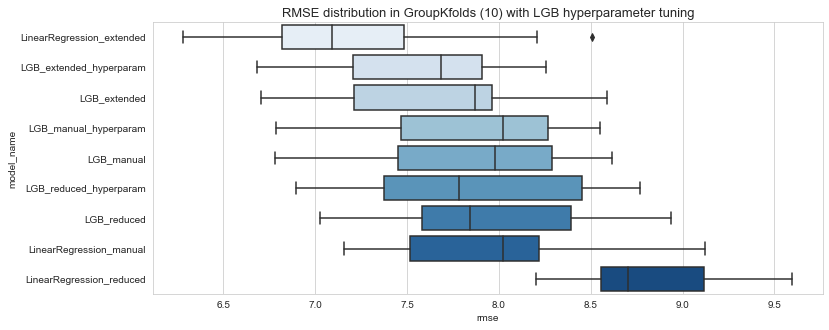

In [113]:
# gather results of all previous results
df_results_sel_extended = pd.read_pickle('df_results_sel_extended.pkl')
df_results_sel_reduced = pd.read_pickle('df_results_sel_reduced.pkl')
df_results_sel_manual = pd.read_pickle('df_results_sel_manual.pkl')
df_results_tot = pd.concat([df_results_sel_extended,df_results_sel_reduced,df_results_sel_manual], axis=0)
df_results_tot = df_results_tot.abs()

# create model name column
df_results_tot = df_results_tot.reset_index().rename(columns={'index':'model_name'})

# keep only the regression and the LGB original models
df_results_tot = df_results_tot.loc[(df_results_tot.model_name.str.contains('LGB')) | (df_results_tot.model_name.str.contains('Linear'))]

# add hyperparameter outer fold results
df_results_lgb_extended = pd.DataFrame(pd.read_pickle('list_extended_lgb_outer.pkl'), columns=['LGB_extended_hyperparam']).T.reset_index().rename(columns={'index':'model_name'})
df_results_lgb_reduced = pd.DataFrame(pd.read_pickle('list_reduced_lgb_outer.pkl'), columns=['LGB_reduced_hyperparam']).T.reset_index().rename(columns={'index':'model_name'})
df_results_lgb_manual = pd.DataFrame(pd.read_pickle('list_manual_lgb_outer.pkl'), columns=['LGB_manual_hyperparam']).T.reset_index().rename(columns={'index':'model_name'})

# bring results together
df_results_final = pd.concat([df_results_tot,df_results_lgb_extended,df_results_lgb_reduced,df_results_lgb_manual], axis=0)

# rank on median rmse
df_results_final['mean_rmse'] = df_results_final.mean(axis=1)
df_results_final = df_results_final.sort_values(by=['mean_rmse'], ascending=True)
df_results_final.drop(columns=['mean_rmse'], inplace=True)

# change layout for plotting purposes
df_cv_rmse_plot = df_results_final.melt(id_vars='model_name', 
        var_name="fold", 
        value_name="rmse")

# visualise
sns.set_style("whitegrid")

fig, ((ax1)) = plt.subplots(1, 1,figsize=(12,5))

sns.boxplot(y="model_name", x="rmse", data=df_cv_rmse_plot, orient="h",palette="Blues", ax=ax1)
ax1.set_title('RMSE distribution in GroupKfolds (10) with LGB hyperparameter tuning', fontsize=13);

**Observations** 

It seems the generalization error for hyperparameter tuning the models did place those models somewhat higher in ranking compared to the original ones. However, the differences are very small and we see the boxes overlap. This means they don't really differ. That is for some models we see the median falling outside of the box of another indicating there could be a difference. The same holds when including the results of the regression. For the purpose of showing two final results on our final holdout (out-of-time) set we will use the linear regression with a lot of variables and the manual LightGBM model (more parsimonious). We will use the hyperparameters which came up as best most often from the innerfolds for each outer fold. Note that this is not a "normal" procedure. After nested cross-validation one "should" do the hyperparameter tuning again, but now on the complete trainingset. Another practice could be to to create ensemblesfrom the best nested cross-validation inner models. But since the inner model configuration seems quite stable we chose to use one hyperparameter result, namely: 

colsample_bytree = 0.9042065818645788, min_child_samples = 308, min_child_weight= 1e-05, num_leaves= 46, reg_alpha = 50, reg_lambda= 0, subsample= 0.9338198537228333

## Part 3 Comparison of final model results of Linear Regression and LightGBM with hyperparameter tuning

We first calculate the results for the regression model

In [6]:
# initiate model. Note: before running run cel 5 to create the dataset

lin_reg = LinearRegression()

# Define train and test (out-of-time) datasets
X_train = df_extended_train.drop(columns=['hr','filename'])
y_train = df_extended_train.hr

X_test = df_extended_holdout.drop(columns=['hr','filename']) 
y_test = df_extended_holdout.hr

# fit the linear regression model
lin_reg.fit(X_train, y_train);

In [7]:
# invoke function to calculate performance metrics on holdout set
df_metrics_final_linreg = metrics_feat_sel(X_test, df_extended_holdout, y_test, lin_reg, 'model_linreg_extended', scaled_test_set = False)

Mean RMSE over files 5.656133623617076
Total RMSE 6.268221842478976
R2 test 0.8449468217290326


In [8]:
# predict on holdout set
df_extended_holdout['pred_hr'] = lin_reg.predict(X_test)

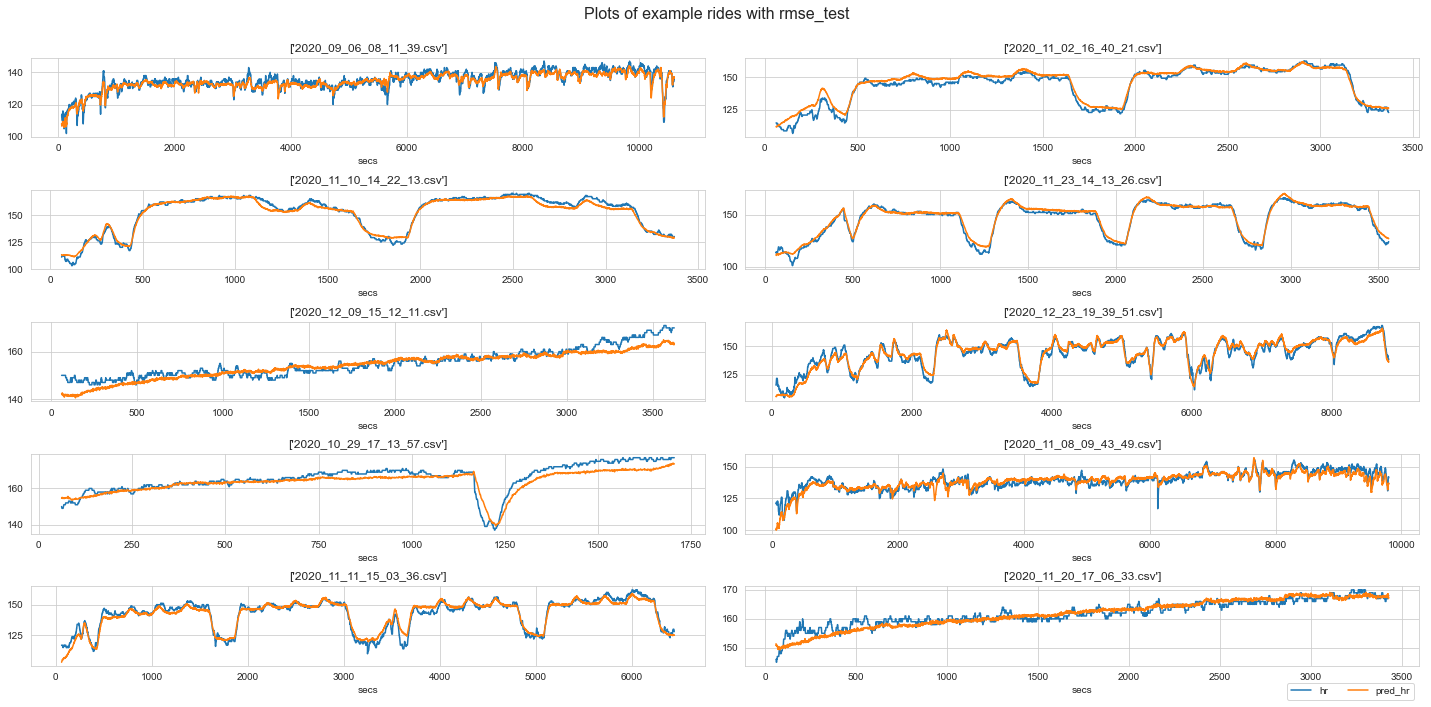

In [127]:
# invoke function and plot top 10 best predictions
graph_rides_model_performance(df_extended_holdout, df_metrics_final_linreg, 10, 'rmse_test', False, 5, 2)

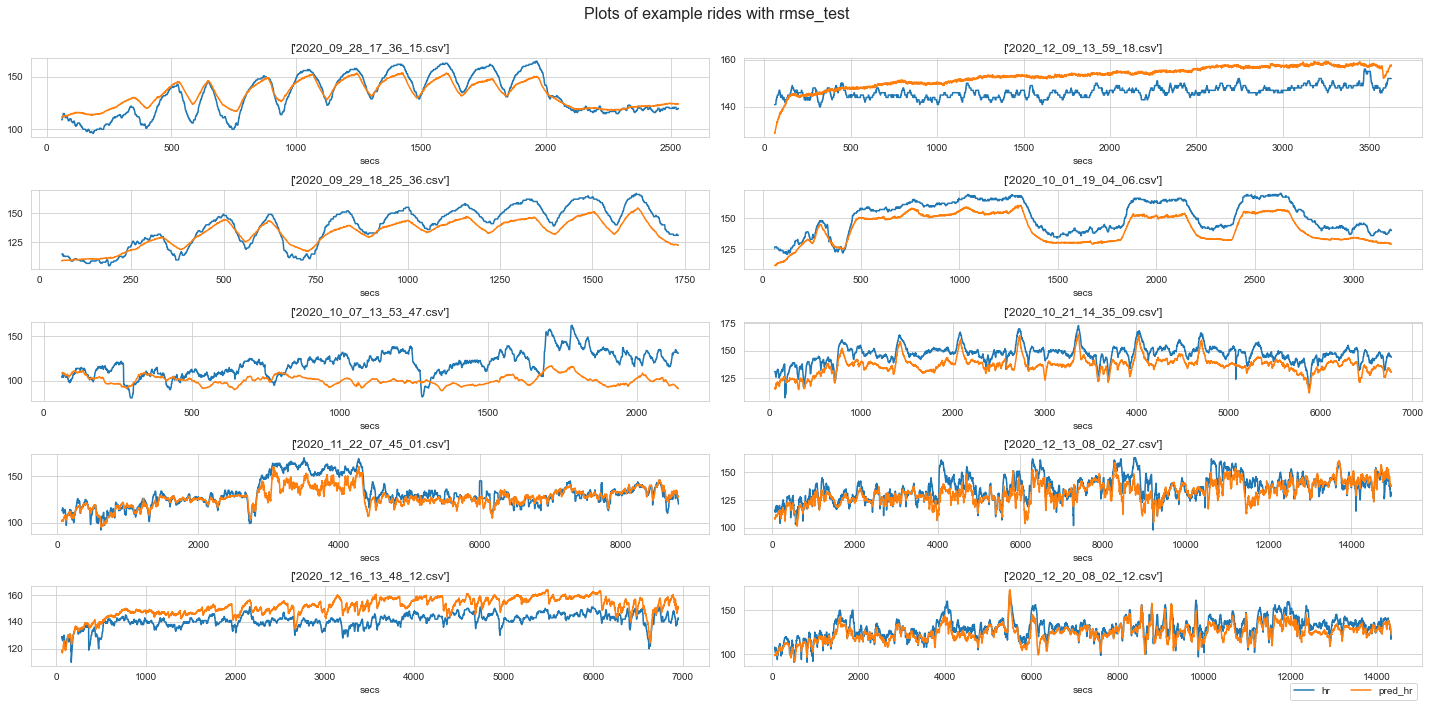

In [128]:
# invoke function and plot top 10 worst predictions
graph_rides_model_performance(df_extended_holdout, df_metrics_final_linreg, 10, 'rmse_test', True, 5, 2)

### Determine feature importance

For the linear regression it is a more “difficult” process to determine how the variables impact the predictions. Since the variables correlate (highly) simply interpreting (standardized) beta coefficients is not an option. Several methods exist to get an idea on feature importance like SHAP values, dominance analysis and relative importance analysis. All of these methods are very computational intensive so to get an _indication_ on which variables are important we used the results of a stepwise procedure. If we look results from a stepwise selection procedure (**3. Feature exploration and selection.ipynb**) we see the following 10 variables appearing (in order)

In [31]:
# read our results back in from 3. Feature exploration and selection.ipynb
read_dictionary = np.load('sfs_dict_results.npy',allow_pickle='TRUE').item()

# print variables in each step
for i in range(10):
    print(i+1, read_dictionary[i+1]["feature_names"])
    
# Top 10 variables:

# CP_scaled_60s_sma_watts, Nonzero_Average_Power, sqrt_secs, Average_Power, CP_scaled_cum_average_watts, 
# exp_cum_total_cad, Relative_Intensity, CP_scaled_NP_EMA, Average_Cadence and CP_scaled_60s_sma_watts

1 ('CP_scaled_60s_sma_watts',)
2 ('Nonzero_Average_Power', 'CP_scaled_60s_sma_watts')
3 ('sqrt_secs', 'Nonzero_Average_Power', 'CP_scaled_60s_sma_watts')
4 ('sqrt_secs', 'Average_Power', 'Nonzero_Average_Power', 'CP_scaled_60s_sma_watts')
5 ('sqrt_secs', 'Average_Power', 'Nonzero_Average_Power', 'CP_scaled_cum_average_watts', 'CP_scaled_60s_sma_watts')
6 ('sqrt_secs', 'exp_cum_total_cad', 'Average_Power', 'Nonzero_Average_Power', 'CP_scaled_cum_average_watts', 'CP_scaled_60s_sma_watts')
7 ('sqrt_secs', 'exp_cum_total_cad', 'Average_Power', 'Relative_Intensity', 'Nonzero_Average_Power', 'CP_scaled_cum_average_watts', 'CP_scaled_60s_sma_watts')
8 ('sqrt_secs', 'exp_cum_total_cad', 'Average_Power', 'Relative_Intensity', 'Nonzero_Average_Power', 'CP_scaled_cum_average_watts', 'CP_scaled_60s_sma_watts', 'CP_scaled_NP_EMA')
9 ('sqrt_secs', 'exp_cum_total_cad', 'Average_Cadence', 'Average_Power', 'Relative_Intensity', 'Nonzero_Average_Power', 'CP_scaled_cum_average_watts', 'CP_scaled_60s_sma_

We now calculate (train) the results for the LightGBM model

[10]	training's rmse: 10.1258	valid_0's rmse: 8.99656
[20]	training's rmse: 7.65894	valid_0's rmse: 7.97753
[30]	training's rmse: 6.74718	valid_0's rmse: 7.81258
[40]	training's rmse: 6.22179	valid_0's rmse: 7.79506
[50]	training's rmse: 5.85367	valid_0's rmse: 7.71922
[60]	training's rmse: 5.59391	valid_0's rmse: 7.66082
[70]	training's rmse: 5.38857	valid_0's rmse: 7.66625
[80]	training's rmse: 5.22672	valid_0's rmse: 7.66625


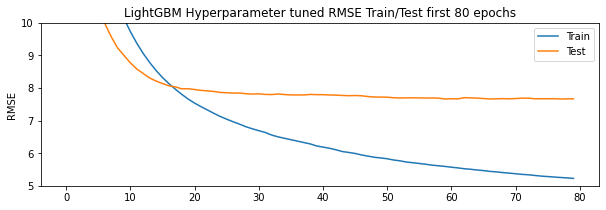

In [12]:
# Define train and test (out-of-time) datasets
X_train = df_manual_train.drop(columns=['hr','filename']) 
y_train = df_manual_train.hr

X_test = df_manual_holdout.drop(columns=['hr','filename']) 
y_test = df_manual_holdout.hr

# We manually put the hyperparameters in as mentioned above

model_lgb_final = lgb.LGBMRegressor(objective='rmse', seed=101, num_threads=1, n_estimators= 80, importance_type='gain', 
                             colsample_bytree = 0.9042065818645788, min_child_samples = 308, min_child_weight= 1e-05, num_leaves= 46, reg_alpha = 50, reg_lambda= 0, subsample= 0.9338198537228333)

model_lgb_final.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)], eval_metric='rmse', verbose=10)

# plot rmse development over iterations
epochs = len(model_lgb_final.evals_result_['valid_0']['rmse'])
#x_axis = range(0, epochs)
x_axis = range(0,80)

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(x_axis, model_lgb_final.evals_result_['training']['rmse'][:epochs], label='Train')
ax.plot(x_axis, model_lgb_final.evals_result_['valid_0']['rmse'][:epochs], label='Test')
ax.legend()
plt.ylabel('RMSE')
plt.title('LightGBM Hyperparameter tuned RMSE Train/Test first 80 epochs')
plt.ylim(5,10)
plt.show()

**Observations**

We see that the model training set can still be improved, but that the performance of our holdout set starts to stabilize. We did train longer (n_estimators = 200), and we observed first a slight overfitting behaviour and after around 125 rounds a drop in RMSE again, which looked like "double descent" behaviour (this is a topic of research in the deep learning community). We however left the model with the current configuration.

In [13]:
# invoke function to calculate performance metrics on holdout set
df_metrics_final_lightgbm = metrics_feat_sel(X_test, df_manual_holdout, y_test, model_lgb_final, 'model_lgb_manual', scaled_test_set = False)

Mean RMSE over files 6.459780832732488
Total RMSE 7.666254330735067
R2 test 0.7680692128360456


In [14]:
# predict on holdout set
df_manual_holdout['pred_hr'] = model_lgb_final.predict(X_test)

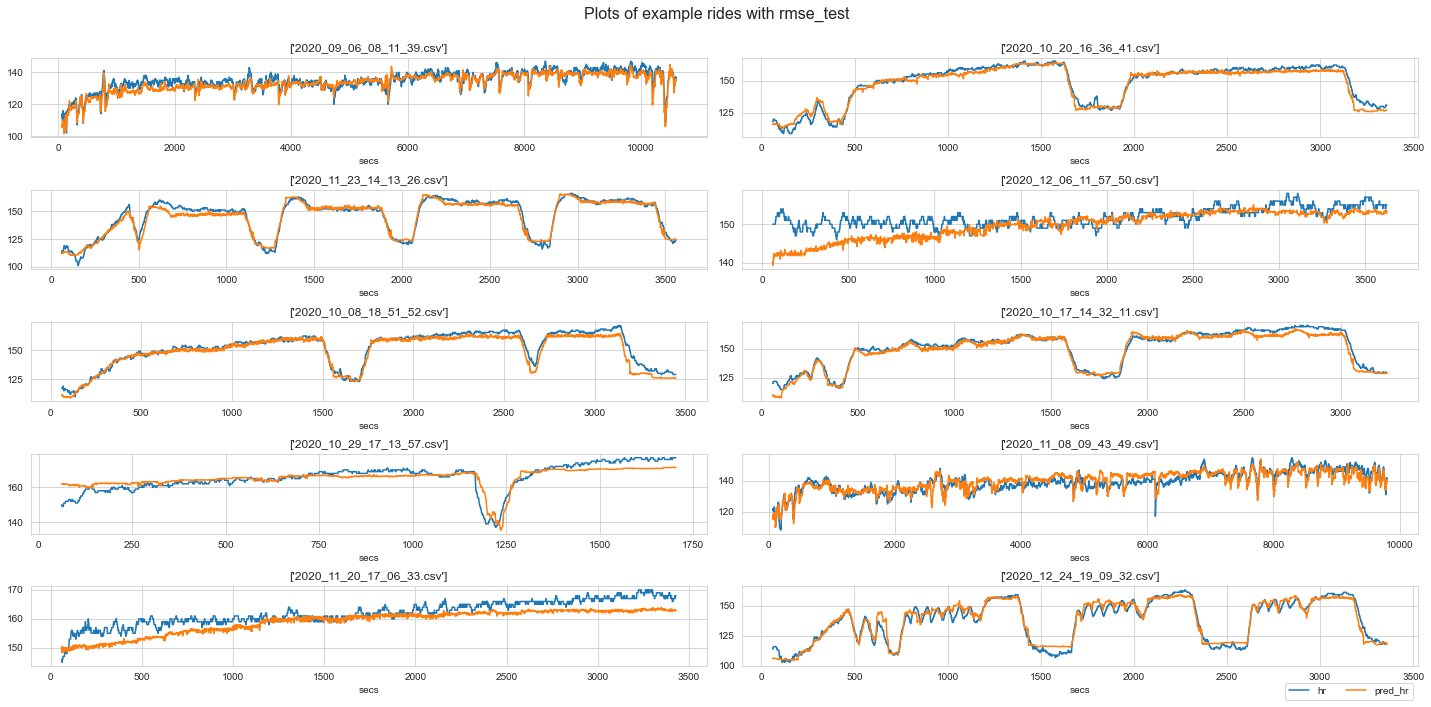

In [133]:
# invoke function and plot top 10 best predictions
graph_rides_model_performance(df_manual_holdout, df_metrics_final_lightgbm, 10, 'rmse_test', False, 5, 2)

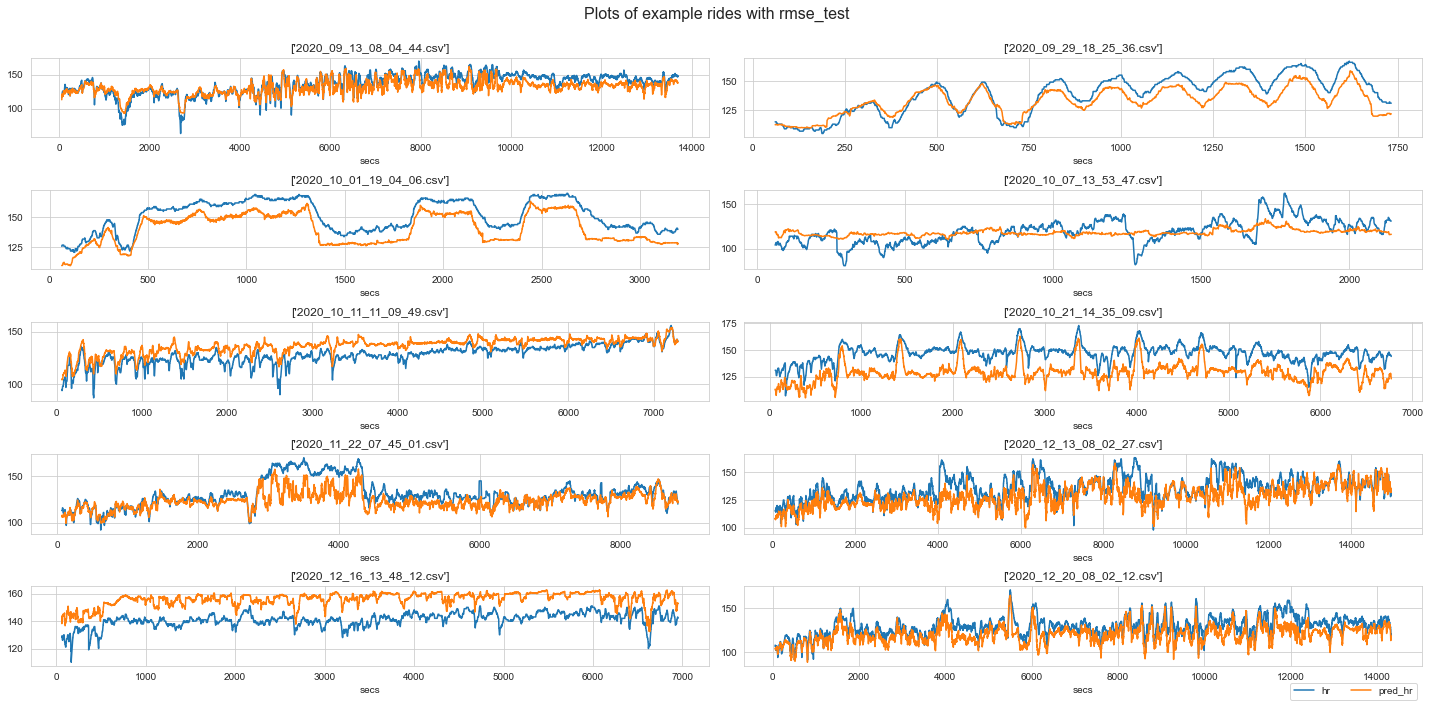

In [134]:
# invoke function and plot top 10 best predictions
graph_rides_model_performance(df_manual_holdout, df_metrics_final_lightgbm, 10, 'rmse_test', True, 5, 2)

### Determine feature importance

Plot feature importances LightGBM using (SHAP)ely values

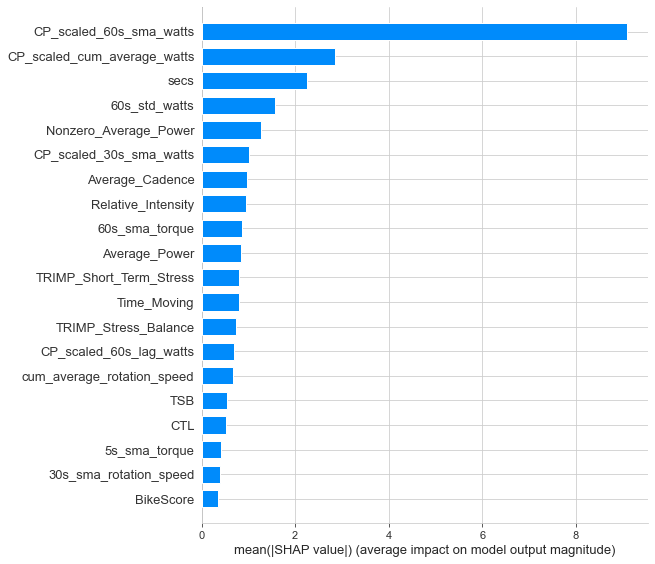

In [142]:
# explain the model's predictions using SHAP

explainer = shap.TreeExplainer(model_lgb_final)
shap_values = explainer.shap_values(X_test)

# Top 20 of most important features for model prediction
shap.summary_plot(shap_values, X_test, plot_type="bar")

**Observations** 

The scaled 60 second CP SMA watts is the most important feature in our LightGBM model, that is the overall average impact on the model prediction is largest. In addition we see that there is quite a large overlap between the top 10 variables and the variables in linear regression order in which features would be added to stepwise reduce RMS

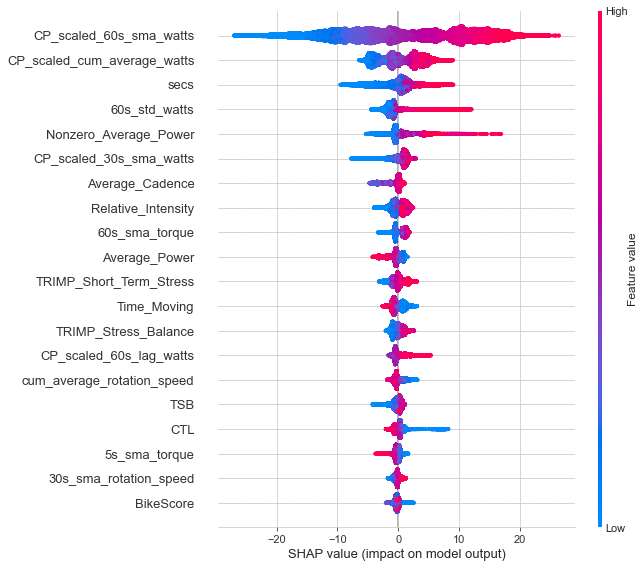

In [144]:
# summarize the effects of all the features per datapoint
shap.summary_plot(shap_values, X_test)

In [28]:
# Make dataframes of the RMSE distributions for both models to compare

df_metrics_models_final_tot = pd.concat([df_metrics_final_linreg, df_metrics_final_lightgbm], axis=0)

df_metrics_models_final_tot_1 = pd.concat([df_metrics_final_linreg[['rmse_test']].rename(columns={'rmse_test':'rmse_lin_reg'}), df_metrics_final_lightgbm[['rmse_test']].rename(columns={'rmse_test':'rmse_light_gbm'})], axis=1)

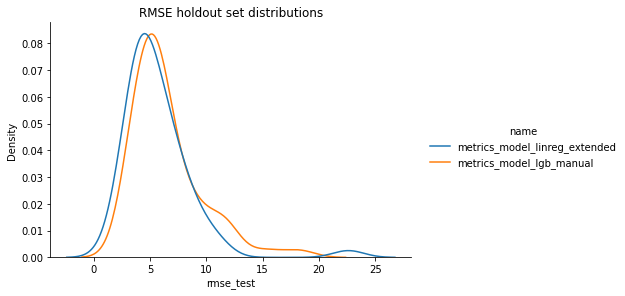

In [53]:
# plot distributions of RMSE on holdout set

sns.displot(df_metrics_models_final_tot, x="rmse_test", hue="name", kind="kde", height=4, aspect=1.5, )
plt.title('RMSE holdout set distributions', fontweight=14);

We see that structurally the RMSE for the lightGBM RMSE distribution is more to the right

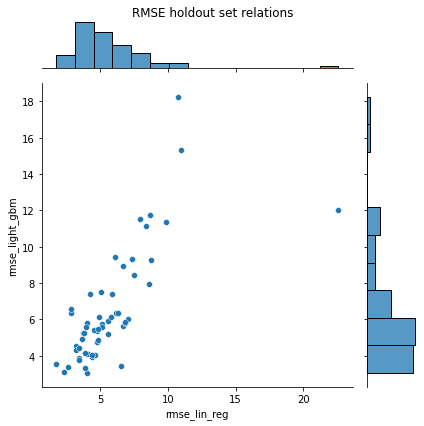

In [36]:
p = sns.jointplot(data=df_metrics_models_final_tot_1, x="rmse_lin_reg", y="rmse_light_gbm")
p.fig.suptitle('RMSE holdout set relations')
#p.ax_joint.collections[0].set_alpha(0)
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95) 

In [28]:
# Test if RMSE distributions on holdout set differ for the models. We evaluate different algorithms on the same data

tStat, pValue = stats.ttest_rel(df_metrics_final_linreg.rmse_test, df_metrics_final_lightgbm.rmse_test) #run independent sample T-Test

print("P-Value:{0} T-Statistic:{1}".format(pValue,tStat)) #print the P-Value and the T-Statistic

# interpret
alpha = 0.05
if pValue > alpha:
    print('Samples distributions are the same (fail to reject H0)')
else:
    print('Samples distributions are different (reject H0)')

P-Value:0.010159270158167854 T-Statistic:-2.6605077597538322
Samples distributions are different (reject H0)


**Observations** 

The RMSE distributions of the models are significantly different

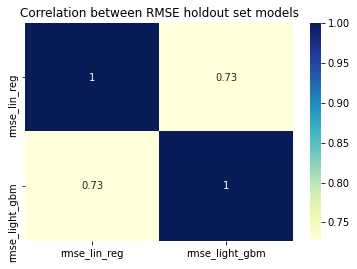

In [43]:
sns.heatmap(df_metrics_models_final_tot_1.corr(), annot=True, cmap = "YlGnBu")
plt.title('Correlation between RMSE holdout set models');

As a final step we save the heart rate predictions from our linear regression model which we will use to calculate the aggregate TRIMP scores for the rides and compare those with a simple baseline model using aggregate metrics in our final notebook **5. Training stress calculations.ipynb**

In [19]:
# score total set
df_extended['pred_hr'] = lin_reg.predict(df_extended.drop(columns=['hr','date','filename']))

# pickle file
df_extended[['filename','date','hr','pred_hr']].to_pickle("df_heart_rate_predictions.pkl")